# **Welcome to your EPAT guided mini project!**

#### Date created: 31/12/2024
#### Created by: EPAT Content Team (Led by José Carlos Gonzáles Tanaka)

<div class="alert alert-warning ">
The objective of EPAT guided projects is to give you a flavour of solving a real-world problem using Python.  

Here's what we'll do.

- We will give you the step-wise process to follow so that you understand how to analyze a problem and break it down into steps.
- We will give hints for the difficult steps. You can use them if you get stuck somewhere. This will make sure that you do not spend too much time stranded at a particular step. 
- **We urge you to search for solutions on the internet too. That's what you'll do in the outdoors and we think it is an essential part of learning to program.**
- You can explore alternate ways to solve the problem.
- Guided projects are not graded or reviewed. You need to code the solution and run it successfully to evaluate your own progress.
- We provide a model solution of the project against which you can compare your code for self-review.
- The duration of this project is ONE week. You need to complete the project within that time.


Let's begin!
</div>

# **Topic: Backtesting an Options Volatility Trading strategy with Delta Hedging**
<div class="alert alert-info ">
    <strong>Problem statement:</strong>

In the OTS module, you learned about volatility trading using options. In this notebook, we provide you with an implementation of a backtesting script using this strategy.

Specifications of the strategy:
- The volatility trading strategy presented here uses a straddle to go short whenever possible.
- The options data has a daily frequency
- We have an event-driven backtesting script iterating each day
- We use delta bands provided by the Whalley-Wilmott approximation to hedge the above strategy
- For each day, we short a straddle whenever we have a straddle signal, and we adjust the straddle delta hedge whenever the straddle delta goes outside the delta bands.
- We compute the profit and loss for each trade we open.

In this project, you will compute the following using Python:
- Determine the ATM Strike prices
- Set the parameters, the entry and exit conditions of the short straddle
- Create the event-driven backtesting loop step-by-step
- Compute trade analytics for all the trades made
- Learn two tips on how to tweak the code to improve the backtesting loop

</div>

<div class="alert alert-info ">
    <strong>Steps to perform for this project:</strong>

1. [Read the Data](#read)
2. [Calculate the ATM Strike](#atm)
3. [Strategy Parameters](#parameters)
4. [Entry Condition](#entry)
5. [Exit Conditions](#exit)
6. [Backtesting](#backtesting)
7. [Trade-Level Analytics](#analytics)
</div>

In [ ]:
# To run the code script smoothly, we suggest having the following installations
# python version 3.12 or higher
# !pip install matplotlib=3.9.2 # or higher
# !pip install numpy=1.26.4 # or higher
# !pip install pandas=2.2.3 # or higher

In [1]:
# For data manipulation
import numpy as np
import pandas as pd
import datetime
import math

#Provides the standard-normal CDF used in the Black-Scholes-Merton pricing formulas.
import scipy.stats as si

#Brent’s method root-finder to numerically solve for the implied volatility that makes the BSM price = market price.
from scipy.optimize import brentq, minimize_scalar
from scipy.stats import norm

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Import the trade analytics function
import trade_analytics_function as taf

import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

<a id='read'></a>
## Read the Data

- Read the following file: `options_data.bz2`
- It contains the chain data from 2016 to 2023 of the SPX EOM (End of Month) options data.

In [2]:
# Read the options data
options_data = pd.read_csv('options_data.csv', index_col=0, parse_dates=True )
# Convert the dates in the options_data to datetime.date() format
options_data['EXPIRE_DATE'] = pd.to_datetime(options_data['EXPIRE_DATE'], errors='raise')
options_data['EXPIRE_DATE'] = options_data['EXPIRE_DATE'].map(lambda x: x.date() if  hasattr(x, 'date') else x)
options_data.index = pd.to_datetime(options_data.index, errors='raise')
options_data.index = options_data.index.map(lambda x: x.date() if  hasattr(x, 'date') else x)
# Print the options data
options_data.head()

,stock_code,EXPIRE_DATE,STRIKE,C_LAST,DTE,UNDERLYING_LAST,P_LAST,IV,IV_1y_max,IV_1y_min,IV Rank,C_DELTA,P_DELTA,std_90%_ci_lower,std_90%_ci_upper,GAMMA
Date,,,,,,,,,,,,,,,,
2021-12-01,NIFTY,2022-01-27,16600,929.75,57,17166.90039,198.75,0.166590,NaN,NaN,NaN,0.778085,-0.221915,0.072387,0.241343,0.000258
2021-12-01,NIFTY,2022-01-27,16650,849.80,57,17166.90039,216.50,0.157661,NaN,NaN,NaN,0.775808,-0.224192,0.072387,0.241343,0.000274
2021-12-01,NIFTY,2022-01-27,16700,788.60,57,17166.90039,222.00,0.150308,NaN,NaN,NaN,0.771169,-0.228831,0.072387,0.241343,0.000291
2021-12-01,NIFTY,2022-01-27,16750,759.05,57,17166.90039,247.15,0.154808,NaN,NaN,NaN,0.750171,-0.249829,0.072387,0.241343,0.000296
2021-12-01,NIFTY,2022-01-27,16800,735.55,57,17166.90039,248.80,0.154808,NaN,NaN,NaN,0.734767,-0.265233,0.072387,0.241343,0.000306


In [ ]:
len(options_data)

Where:
1. **`'STRIKE'`**: The strike price of the options' chain
2. **`'C_LAST'`**: The last call price of the day
3. **`'UNDERLYING_LAST'`**: The last price of the underlying of the day
4. **`'P_LAST'`**: The last put price of the day
5. **`'EXPIRE_DATE'`**: The expiry date of the options' chain
6. **`'DTE'`**: The days to expiry of the options' chain
7. **`'Date'`**: Date

## Calculate IV, IV Rank, Realized Vol 90% CI Upper and Lower Bands, C_DELTA and P_DELTA
1. **`'C_DELTA'`**: The call option's delta
2. **`'P_DELTA'`**: The put option's delta
3. **`'IV'`**: The implied-volatility calculated using BSM option pricing equation
4. **`'IV_Rank'`**: The implied-volatility ranking computed based on the historical data. 

**IV_Rank = (current_iv -                                                                            52_week_IV_low)/(52_week_IV_high-52_week_IV_low)x100**

5. **`'Realized Volatility'`**: Close-to-close volatilty calculated using past 5 years of data

In [ ]:
def bsm_implied_volatility_combined(
    c_mkt, p_mkt, S, K, rf, maturity,
    q=0, current_date=None,
    min_vol=1e-6, max_vol=5.0,
    parity_tol=1e-8
):
    """
    Combines intrinsic check + single‐leg inversion with
    joint least‐squares fitting:
    
    1) Compute intrinsic_call and intrinsic_put.
    2) If c_mkt < intrinsic_call or p_mkt < intrinsic_put:
         • Build synthetic call: c_syn = p_mkt + S e^{-qT} - K e^{-rT}
         • Calculate implied volatility using c_syn.
       Else:
         • Find σ ≥ 0 minimizing [C(σ)-c_mkt]^2 + [P(σ)-p_mkt]^2
           via bounded scalar minimization.
    
    Returns
    -------
    float
        Implied volatility, or np.nan if no valid solution.
    """
    
    
    """
    We calculate two distinct time-to-maturity measures:
        1. **t1 (Trading-day basis)**  
   - Counts only business days until expiration (using a 252-day trading year).  
   - Used to annualize volatility, since observed price fluctuations occur only on days when markets are open.  

        2. **t2 (Calendar-day basis)**  
           - Counts all calendar days until expiration (using a 365-day year).  
           - Used for continuously compounded discounting of cash flows, since interest accrues every day.
    """

    if current_date is None:
        current_date = datetime.date.today()

    # Calculate time to maturity in trading days and calendar days
    trading_days = np.busday_count(current_date, maturity)
    calendar_days = np.busday_count(current_date, maturity, weekmask='1111111')

    r = rf

    t1 = trading_days / 252  # Trading days to years
    t2 = calendar_days / 365  # Calendar days to years

    if t1 <= 0 or t2 <= 0:
        return np.nan

    # 3. Intrinsic lower bounds
    intrinsic_call = max(S*np.exp(-q*t2) - K*np.exp(-r*t2), 0.0)
    intrinsic_put  = max(K*np.exp(-r*t2) - S*np.exp(-q*t2), 0.0)
    below_intrinsic = (c_mkt < intrinsic_call) or (p_mkt < intrinsic_put)

    # 4. BSM pricing for both call & put
    def bsm_call_put(sigma):
        d1 = (np.log(S/K) + (r-q)*t2 + 0.5*sigma**2*t1) / (sigma*np.sqrt(t1))
        d2 = d1 - sigma*np.sqrt(t1)
        call = S*np.exp(-q*t2)*norm.cdf(d1) - K*np.exp(-r*t2)*norm.cdf(d2)
        put  = K*np.exp(-r*t2)*norm.cdf(-d2) - S*np.exp(-q*t2)*norm.cdf(-d1)
        return call, put

    # 5a. If any leg is below intrinsic → synthetic call + Brent
    if below_intrinsic:
        c_syn = p_mkt + S*np.exp(-q*t2) - K*np.exp(-r*t2)
        def f_call(sigma):
            return bsm_call_put(sigma)[0] - c_syn

        # ensure a sign change
        try:
            vol = brentq(f_call, min_vol, max_vol)
            return vol
        except:
            return np.nan

    # 5b. Otherwise → joint least‐squares fit
    def objective(sigma):
        call, put = bsm_call_put(sigma)
        return (call - c_mkt)**2 + (put - p_mkt)**2

    res = minimize_scalar(
        objective,
        bounds=(min_vol, max_vol),
        method='bounded',
        options={'xatol':1e-6}
    )
    return res.x if res.success else np.nan

In [ ]:
options_data.columns

### **`1. Calculating IV`**

In [ ]:
"""
We assume risk-free rate to be equal to 10% since 10% has been used as risk-free rate to calculate IV 
by National Stock Exchange of India
"""
rf = 0.1
iv_list = []
for idx, r in options_data.iterrows():
    iv = bsm_implied_volatility_combined(c_mkt=r['C_LAST'], p_mkt=r['P_LAST'], S=r['UNDERLYING_LAST'], 
                                         K=r['STRIKE'], rf=rf, maturity=r['EXPIRE_DATE'], q=0, current_date=idx,
                                         min_vol=1e-6, max_vol=5.0, parity_tol=1e-8)
    iv_list.append(iv)
options_data['IV'] = iv_list

In [ ]:
#Saving the options_data to avoid calculating implied volatility again and again
options_data.to_csv('options_data.csv')

### **`2. Calculating IV Rank`**

In [ ]:
options_data = pd.read_csv('options_data.csv', index_col=0, parse_dates=True)
options_data.index = pd.to_datetime(options_data.index)
options_data['EXPIRE_DATE'] = pd.to_datetime(options_data['EXPIRE_DATE'], errors='raise')
options_data.dropna(inplace=True)
options_data.describe()

In [ ]:
# 1) Rolling using the dates
rolled = options_data['IV'].rolling('365D').agg(['max','min'])

# 2) Build a per-row mask based on the dataset’s earliest date
first_date = options_data.index.min()
threshold = first_date + pd.Timedelta(days=365)
mask = options_data.index >= threshold

# 3) Apply the mask
rolled.loc[~mask, ['max','min']] = np.nan
rolled.columns = ['IV_1y_max','IV_1y_min']

# 4) Join back
options_data[['IV_1y_max','IV_1y_min']] = rolled
options_data

In [ ]:
options_data['IV Rank'] = 100 * (options_data['IV'] - options_data['IV_1y_min']) / \
                            (options_data['IV_1y_max'] - options_data['IV_1y_min'])
options_data

### **`3. Calculating call and put delta`**

In [ ]:
def delta(S, K, imp_vol, rf, maturity, option_category, q=0, current_date=None):
    """
    Calculate the option delta using the Black-Scholes formula.
    Uses t2 for drift and discounting, and t1 for volatility scaling.
    """
    if current_date is None:
        current_date = datetime.date.today()

    # Calculate time to maturity in trading days and calendar days
    trading_days = np.busday_count(current_date, maturity)
    calendar_days = np.busday_count(current_date, maturity, weekmask='1111111')

    t1 = trading_days / 252  # Trading days to years
    t2 = calendar_days / 365  # Calendar days to years

    if t1 <= 0 or t2 <= 0:
        return np.nan
    
    # Compute d1 using t2 for the drift term and t1 for volatility.
    d1 = (np.log(S / K) + (rf - q) * t2 + 0.5 * imp_vol ** 2 * t1) / \
         (imp_vol * np.sqrt(t1))

    if option_category == 'CE':
        # Call delta: exp(-q*t2) * N(d1)
        delta = np.exp(-q * t2) * si.norm.cdf(d1)
    elif option_category == 'PE':
        # Put delta: exp(-q*t2) * (N(d1) - 1) which is equivalent to -exp(-q*t2)*N(-d1)
        delta = np.exp(-q * t2) * (si.norm.cdf(d1) - 1)
    else:
        raise ValueError("option_category must be 'CE' (call) or 'PE' (put)")

    return delta

In [ ]:
options_data.columns

In [ ]:
c_delta = []
p_delta = []
options_data.index = options_data.index.map(lambda x: x.date() if  hasattr(x, 'date') else x)
options_data['EXPIRE_DATE'] = options_data['EXPIRE_DATE'].map(lambda x: x.date() if  hasattr(x, 'date') else x)
for idx, r in options_data.iterrows():
    call_delta = delta(S=r['UNDERLYING_LAST'], K=r['STRIKE'], imp_vol=r['IV'], 
                       rf=0.1, maturity=r['EXPIRE_DATE'], option_category='CE', q=0, current_date=idx)
    put_delta = delta(S=r['UNDERLYING_LAST'], K=r['STRIKE'], imp_vol=r['IV'], 
                       rf=0.1, maturity=r['EXPIRE_DATE'], option_category='PE', q=0, current_date=idx)
    c_delta.append(call_delta)
    p_delta.append(put_delta)
    
options_data['C_DELTA'] = c_delta
options_data['P_DELTA'] = p_delta

In [ ]:
options_data

In [ ]:
#Saving the options_data to avoid repeated calculations
options_data.to_csv('options_data.csv')

In [ ]:
options_data.describe()

### **`4. Calculating close-to-close volatility and its 90% CI bounds`**

In [ ]:
data = yf.Ticker("^NSEI")
daily_close = data.history(period='5y')[['Close']]
daily_close.index = daily_close.index.map(lambda x: x.date() if  hasattr(x, 'date') else x)

In [ ]:
daily_close.head()

In [ ]:
log_returns = (daily_close['Close']/daily_close['Close'].shift(1)).apply(np.log)
rolling_window_std = log_returns.rolling(window=20, center=False).std() * math.sqrt(252)
rolling_window_std.tail()

In [ ]:
#Function to compute the 5th and 95th percentiles over the past year
def get_std_ci(date):
    start = date - pd.DateOffset(years=1)
    window = rolling_window_std.loc[start:date].dropna()
    return window.quantile(0.05), window.quantile(0.95)

In [ ]:
#Make sure both indices are datetime
rolling_window_std.index = pd.to_datetime(rolling_window_std.index)
options_data.index = pd.to_datetime(options_data.index)

ci_list = [get_std_ci(d) for d in options_data.index]
ci_df = pd.DataFrame(ci_list,
                     index=options_data.index,
                     columns=['std_90%_ci_lower', 'std_90%_ci_upper'])
ci_df.head()

In [ ]:
options_data[['std_90%_ci_lower','std_90%_ci_upper']] = ci_df
options_data

In [ ]:
#Saving the options_data to avoid repeated calculations
options_data.to_csv('options_data.csv')

### **`4. Calculating gamma`**

In [ ]:
def gamma(S, K, imp_vol, rf, maturity, q=0, current_date=None):
    """
    Calculate the option gamma using the Black-Scholes formula.
    Gamma is identical for calls and puts.
    """
    if current_date is None:
        current_date = datetime.date.today()

    # Calculate time to maturity in trading days and calendar days
    trading_days = np.busday_count(current_date, maturity)
    calendar_days = np.busday_count(current_date, maturity, weekmask='1111111')

    t1 = trading_days / 252  # Trading days to years
    t2 = calendar_days / 365  # Calendar days to years

    if t1 <= 0 or t2 <= 0:
        return np.nan
    
    # d1 remains the same as in delta.
    d1 = (np.log(S / K) + (rf - q) * t2 + 0.5 * imp_vol ** 2 * t1) / \
         (imp_vol * np.sqrt(t1))

    # Gamma: exp(-q*t2)*phi(d1) / (S * sigma * sqrt(t1))
    gamma = (si.norm.pdf(d1) * np.exp(-q * t2)) / (S * imp_vol * np.sqrt(t1))

    return gamma

In [ ]:
gamma_list = []
options_data.index = options_data.index.map(lambda x: x.date() if  hasattr(x, 'date') else x)
options_data['EXPIRE_DATE'] = options_data['EXPIRE_DATE'].map(lambda x: x.date() if  hasattr(x, 'date') else x)
for idx, r in options_data.iterrows():
    g = gamma(S=r['UNDERLYING_LAST'], K=r['STRIKE'], imp_vol=r['IV'], 
                       rf=0.1, maturity=r['EXPIRE_DATE'], q=0, current_date=idx)
    gamma_list.append(g)
    
options_data['GAMMA'] = gamma_list

In [ ]:
options_data

In [ ]:
#Saving the options_data to avoid repeated calculations
options_data.to_csv('options_data.csv')

<a id='atm'></a>
## Calculate the ATM Strike

Do the following:
1. Determine the appropriate interval for rounding strike prices based on the `strike_price_multiple`.
2. Calculate the ATM strike price by
    - Rounding the underlying asset's price to the nearest multiple of strike_price_multiple.
        - Divide the underlying price data from the `options_data` by the strike price multiple and round it to 0 decimals.
        - Multiple the above result by the strike price multiple
    - Add the calculated ATM strike price to the options_data DataFrame in the `atm` column.
4. Display the last 5 rows of the updated DataFrame for inspection.

In [3]:
# To find the interval at which strike prices are rounded, set the strike multiple
strike_price_multiple = 50

# Find the strike price for the ATM
# Round the most recent price of the underlying asset to the closest multiple of the strike_price_multiple 
# to determine the ATM strike price
options_data['atm'] = strike_price_multiple * (round(options_data['UNDERLYING_LAST'] / strike_price_multiple))

# Show the last 5 rows of the options data
options_data.tail()

,stock_code,EXPIRE_DATE,STRIKE,C_LAST,DTE,UNDERLYING_LAST,P_LAST,IV,IV_1y_max,IV_1y_min,IV Rank,C_DELTA,P_DELTA,std_90%_ci_lower,std_90%_ci_upper,GAMMA,atm
Date,,,,,,,,,,,,,,,,,
2024-12-24,NIFTY,2024-12-26,23750,108.45,2,23727.65039,88.70,0.116787,0.451281,0.095396,6.010536,0.486988,-0.513012,0.078415,0.295108,0.001615,23750.0
2024-12-24,NIFTY,2024-12-26,23800,83.50,2,23727.65039,113.25,0.113055,0.451281,0.095396,4.961928,0.404063,-0.595937,0.078415,0.295108,0.001621,23750.0
2024-12-24,NIFTY,2024-12-26,23850,63.60,2,23727.65039,143.85,0.110938,0.451281,0.095396,4.367041,0.322753,-0.677247,0.078415,0.295108,0.001530,23750.0
2024-12-24,NIFTY,2024-12-26,23900,48.35,2,23727.65039,178.75,0.109397,0.451281,0.095396,3.934003,0.247771,-0.752229,0.078415,0.295108,0.001368,23750.0
2024-12-24,NIFTY,2024-12-26,23950,36.95,2,23727.65039,215.65,0.106521,0.451281,0.095396,3.125918,0.178680,-0.821320,0.078415,0.295108,0.001160,23750.0


<a id='parameters'></a>
## Strategy Parameters

Both `num_days_before_expiry` and `delta_threshold` are our two parameters.

1. In order to avoid keeping the position until expiry and avoid large MTM (mark-to-market) movements as the expiration date draws near, set `num_days_before_expiry` to `3`. 

3. Set `delta_threshold` to `0.5`, which means that if the strategy's net delta rises over `0.5` or goes below `-0.5`, we shall rebalance the delta to make it come back to `0`.

These characteristics can be changed based on your trading requirements or needs.

In [4]:
# Set the config dictionary
config = {
    'num_days_before_expiry': 3,
    'delta_threshold': 0.5
}

<a id='entry'></a>
## Entry Condition

The following requirements for admittance will be examined:
1. An IV rank of 50 or higher is required.

Make a column called `signal` that will hold `1` if the criteria is satisfied and `NaN` otherwise.

In [10]:
# Verify if the IV Rank is equal to or higher than 50
options_data['signal'] = np.where(options_data['IV Rank'] >= 50, 1, np.nan)

#Verify if IV is greater than 90% CI upper limit of historical volatility of the underlying
options_data['signal'] = np.where((options_data['IV'] > options_data['std_90%_ci_upper']), 1, options_data['signal'])

<a id='exit'></a>
## Exit Conditions
We will look for any one of the two exit requirements listed below:

1. The `num_days_before_expiry` is equal to or fewer than the days to expiry listed in the ` [DTE]` column of the `options_data` dataframe. Since we don't intend to take any new positions during these days, we shall keep `0` in the `signal` column.
    1. Set the `signal` to `0` if ` [DTE]` is lower than or equal to `config['num_days_before_expiry']`, otherwise, set it to the `signal` column.
    2. Set the `trade_exit_type` to `expiry_exit` if ` [DTE]` is lower than or equal to `config['num_days_before_expiry']`, otherwise, set it to the `expiry_exit` column.

3. In case you want to add them, here you have two optional exit conditions:
    1. Related to the IV rank
        1. Set the `signal` to `0` if the IV rank is less than `30`, otherwise, set it to the `signal` column.
        2. Set the `trade_exit_type` to `iv_rank_exit` if the IV rank is less than `30`, otherwise, set it to the `trade_exit_type` column.
    2. Related to the Skew rank
        1. Set the `signal` to `0` if the skew rank is either greater than or equal to `90`, or less than or equal to `10`, otherwise, set it to the `signal` column.
        2. Set the `trade_exit_type` to `iv_rank_exit` if the skew rank is either greater than or equal to `90`, or less than or equal to `10`, otherwise, set it to the `trade_exit_type` column.

In [11]:
# Set the trade_exit_type column as NaN
options_data['trade_exit_type'] = np.nan

# If DTE is less than days to exit before expiry then we do not take an entry
options_data['signal'] = np.where(options_data['DTE'] <= config['num_days_before_expiry'], 0, options_data['signal'])
options_data['trade_exit_type'] = np.where(options_data['DTE'] <= config['num_days_before_expiry'], 'expiry_exit', 
                                           options_data['trade_exit_type'])

In [12]:
###################################################################################################
# Optional Exit conditions
###################################################################################################
# If IV rank is less than 30, set'signal' to 0
# options_data['signal'] = np.where((options_data[____] < ____), ____, options_data[____])
# options_data['trade_exit_type'] = np.where((options_data[____] < ____), ____, options_data[____])

# If skew rank is less than or equal to 10 or more than or equal to 90, set 'signal' to 0
# options_data['signal'] = np.where((options_data[____] <= ____) | (options_data[____] >= ____), ____, options_data[____])
# options_data['trade_exit_type'] = np.where((options_data[____] <= ____) | (options_data[____] >= ____), ____, options_data[____])

In [13]:
options_data['signal'].value_counts()

signal
0.0    2495
1.0    1619
Name: count, dtype: int64

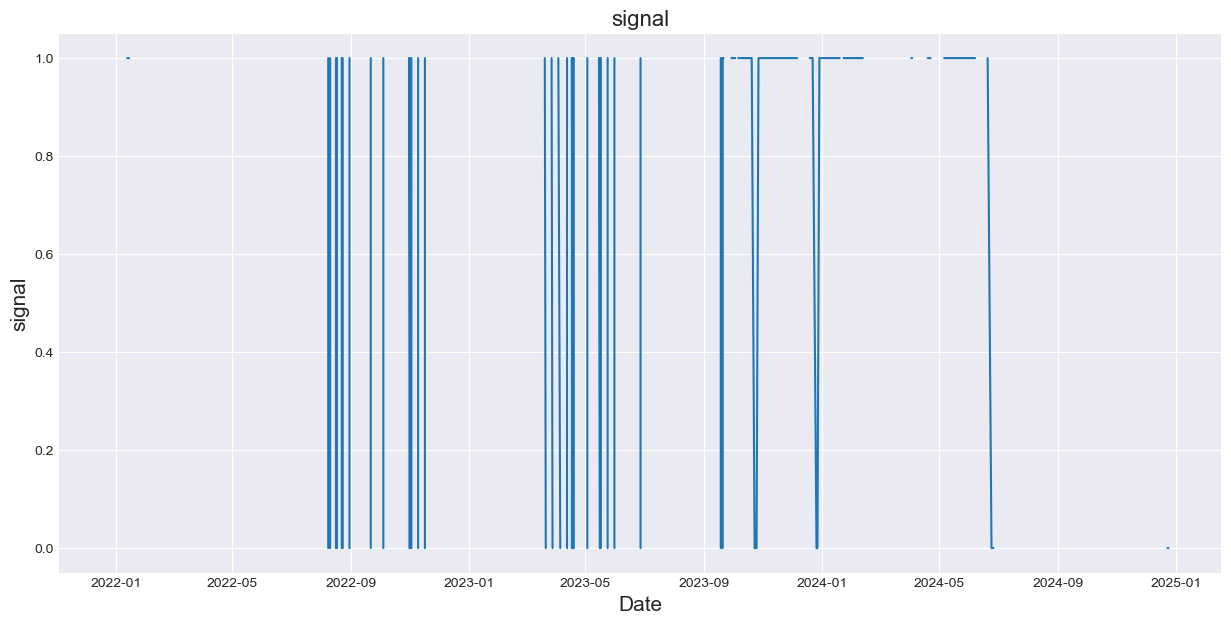

In [14]:
# Set the plot
plt.figure(figsize=(15, 7))
# Plot the signal column in the options_data
options_data['signal'].plot()
# Set the plot title
plt.title('signal', fontsize=16)
# Set the plot x-axis title
plt.xlabel('Date', fontsize=15)
# Set the plot y-axis title
plt.ylabel('signal', fontsize=15)
# Show the plot
plt.show()

<a id='backtesting'></a>
## Backtesting script

Each date in the data will be looped over, the straddle will be set up when the value in the `signal` column is `1`, the trade will be updated in `trade_details`, and the delta will be rebalanced by taking a position in the underlying asset when the delta rebalancing condition is satisfied.

The strategy's option premiums, delta values, and underlying exposure for each date between the entry and exit dates are all contained in the `mtm_data` dataframe.

The following procedures will be used to backtest the straddle strategy:

**Step 1** 
1. To store round trips, trades, mark-to-market values, and adjustments, create their empty dataframes as `trade_details`, `trades`, `mtm_data`, and `adjustments`, respectively.
    - The mtm_data dataframe is to update the trade position details
    - The adjustments dataframe is for saving the upcoming new trades information regarding the delta hedging
    - The trade_details dataframe is for saving all the trades information
2. Create an `adjustaments` dataframe with the following columns: `trade_id`, `trade_entry_date`, `trade_position`, `delta_value` and `trade_entry_price`.

In [15]:
# Set up dataframes for the trade details, the trades and the mark-to-market data
# To document all the trade's specifics
trade_details = pd.DataFrame()
# To record individual trades
trades = pd.DataFrame()
 # To record mark-to-market valuations
mtm_data = pd.DataFrame()

# Initialise adjustments DataFrame
adjustments = pd.DataFrame(columns=['trade_id', 'trade_entry_date', 'trade_position', 'delta_value', 'trade_entry_price'])

**Step 2** 

2.1. Set up `curr_position` to monitor if we have a position at the moment. Set it as `0`.

2.2. To maintain track of the quantity of deals, set `trade_id` to `0`. 

2.3. To monitor cumulative profit and loss, set `cum_pnl` to `0`. In order to signal whether an exit condition has been met, set the `trade_close_flag` to `False`. 

2.4. Since there isn't a position at first, set the `underlying_position` to `0` and the `first_underlying_price` to `None`. 

2.5 Set the `lot_size`to 5. This means you will be shorting or buying 5 straddles per trade.

In [16]:
# Initialize variables for current position, trade id number, cumulative PnL, and underlying position as 0
# Initial position is zero
curr_position = 0  
# Trade count starts at zero
trade_id = 0 
# Cumulative PnL starts at zero
cum_pnl = 0  
# Initialize a flag to indicate whether to exit a position to False
trade_close_flag = False  
# No initial position in the underlying asset
underlying_position = 0  
# Initial the price of the underlying asset (to be set later) to None
first_underlying_price = None
# The lot size to trade
lot_size = 5

**Step 3** 

The Whalley-Wilmott approximation offers a practical approach to hedging options when transaction costs are present. It centers around the concept of "delta bands," which define a range around the Black-Scholes delta where no trading action is taken. To hedge, we're going to use this type of band. First, let's set some variables (The variables set here and the formula applied to compute the bands are based on the OTS module. Please refer to the OTS-05 lecture for a detailed explanation of the subject).

3.1 Set the annual risk-free rate `annual_rate` to compute the Whalley-Wilmott-approximation-based delta bands.

3.2 Set the `broker_lambda` as the proportional transaction cost. You should check your broker's commission scheme to specify it here.

3.3 Set your risk-aversion ratio `kappa` as per your trade convenience.

In [17]:
# risk-free rate
annual_rate = 0.1
# Proportional transaction cost per each straddle contract
broker_lambda = 0.05/100
# risk-aversion rate
kappa = 75.6

**Step 4**: Create a function called `update_mtm_data` that keeps track of the strategy's daily mtm_data values. 
- The function inputs are:
    1. The current `mtm_data` dataframe
    2. The `option_strategy` that will combine straddle and delta-hedging adjustments,
    3. The `trading_date` that will represent the date of corresponding trade made.

In [18]:
# Function for calculating mark to market
def update_mtm_data(mtm_data, option_strategy, trading_date):
    # Save the trading date in the option_strategy dataframe
    option_strategy['date'] = trading_date
    # Concatenate the option_strategy data with the mtm_data
    mtm_data = pd.concat([mtm_data, option_strategy])
    return mtm_data

**Step 5**: Define the function `compute_mtm_adjustment` to determine the adjustments' mark-to-market value.
- This part calculates the price difference between the current price of the underlying asset `underlying_price` and the price at which the trade was initially entered `row['trade_entry_price']`.
- Multiply the above with the `row['trade_position']`. This represents the direction of the trade (e.g., 1 for long, -1 for short).

In [19]:
# Function to calculate the mark-to-market value of adjustments
def compute_mtm_adjustment(row, underlying_price):
    # Subtract the row's entry price to the underlying price and multipliy the result by the row trade position
    return (underlying_price - row['trade_entry_price']) * row['trade_position']

**Step 6**: To obtain the premium for the straddle's two legs (CE and PE), define the function `get_option_premium`. It accepts two inputs: `options_strategy` and `options_data`.
- If the `type_of_asset` is a call option, then return the call last price
- If the `type_of_asset` is a put option, then return the put last price

In [20]:
options_data.columns

Index(['stock_code', 'EXPIRE_DATE', 'STRIKE', 'C_LAST', 'DTE',
       'UNDERLYING_LAST', 'P_LAST', 'IV', 'IV_1y_max', 'IV_1y_min', 'IV Rank',
       'C_DELTA', 'P_DELTA', 'std_90%_ci_lower', 'std_90%_ci_upper', 'GAMMA',
       'atm', 'signal', 'trade_exit_type'],
      dtype='object')

In [21]:
# Function for fetching premium
def get_option_premium(options_strategy, options_data):

    # Get the premium for call option
    if options_strategy['type_of_asset'] == "CE":
        # Return the options_data call price last value
        return options_data['C_LAST'].iloc[0]

    # Get the premium for put option
    elif options_strategy['type_of_asset'] == "PE":
        # Return the options_data put price last value
        return options_data['P_LAST'].iloc[0]

**Step 7**

- To obtain the delta for the straddle's two legs (CE and PE), define the method `get_delta_value`. It accepts two inputs: `options_strategy` and `options_data`.
    - If the `type_of_asset` is a call option, then return the call delta value
    - If the `type_of_asset` is a put option, then return the put delta value
- To obtain the gamma for the straddle's two legs (CE and PE), define the method `get_gamma_value`. It accepts two inputs: `options_strategy` and `options_data`.
    - If the `type_of_asset` is a call option, then return the call gamma value
    - If the `type_of_asset` is a put option, then return the put gamma value

In [22]:
# Function for fetching delta
def get_delta_value(options_strategy, options_data):

    # Get the delta for call option
    if options_strategy['type_of_asset'] == "CE":
        # Return the options_data call delta last value
        return options_data['C_DELTA'].iloc[0]

    # Get the delta for put option
    elif options_strategy['type_of_asset'] == "PE":
        # Return the options_data put delta last value
        return options_data['P_DELTA'].iloc[0]

# Function for fetching gamma
def get_gamma_value(options_strategy, options_data):
    
    if options_strategy['type_of_asset'] == "CE":
        # Return the options_data call delta last value
        return options_data['GAMMA'].iloc[0]

    # Get the delta for put option
    elif options_strategy['type_of_asset'] == "PE":
        # Return the options_data put delta last value
        return options_data['GAMMA'].iloc[0]

**Step 8**: To configure the straddle approach, define a function called `setup_straddle`. It accepts two inputs: `options_data` and `direction` (long/short). Inside the function, do the following:
- Create an empty dataframe called `straddle`.
- Create the column `type_of_asset` for the `straddle` dataframe where the values will be `['CE', 'PE']`.
- Set the `strike_price` of the straddle as the first index of the options_data `atm` column.
- Set the `trade_position` to `-1` if the `direction` input is `short`.
- Set the `trade position` to `1` in case the `direction` input is `long`.
- Set the `premium` values for both call and put legs using a `lambda` function together with the `get_option_premium` function by setting its inputs as
    - The `straddle` dataframe, and
    - The `options_data` dataframe
- Set the `delta_value` using a `lambda` function together with the `get_delta_value`function by setting its input as
    - The `straddle` dataframe, and
    - The `options_data` dataframe
- Set the `gamma_value` using a `lambda` function together with the `get_gamma_value`function by setting its input as
    - The `straddle` dataframe, and
    - The `options_data` dataframe

In [23]:
# Function for setting up a straddle
def setup_straddle(options_data, direction='short'):

    # Create a dataframe to store the straddle
    straddle = pd.DataFrame()
    
    # Check if options_data is empty or doesn't contain required columns
    if options_data.empty or 'atm' not in options_data.columns:
        raise ValueError("Invalid options data provided for straddle setup")

    # Save in the type_of_asset column both the CE and PE legs of the straddle
    straddle['type_of_asset'] = ['CE', 'PE']

    # Set the strike_price column of the straddle dataframe to at-the-money price
    straddle['strike_price'] = options_data['atm'].iloc[0]

    # Set the trade_position to -1 for both CE and PE legs in case of a short straddle
    straddle['trade_position'] = -1

    # If the direction is "long"
    if direction == 'long':
        # Set the trade_position to 1 for both CE and PE legs in case of a long straddle
        straddle['trade_position'] = 1

    # Set the premium column to the get_option_premium return value using 
    # each straddle's row info and options_data as the function's inputs
    straddle['premium'] = straddle.apply(lambda r: get_option_premium(r, options_data), axis=1)

    # Set the delta_value column to the get_delta_value return value using 
    # each straddle's row info and options_data as the function's inputs
    straddle['delta_value'] = straddle.apply(lambda r: get_delta_value(r, options_data), axis=1)
    
    # Set the gamma_value column to the get_gamma_value return value using 
    # each straddle's row info and options_data as the function's inputs
    straddle['gamma_value'] = straddle.apply(lambda r: get_gamma_value(r, options_data), axis=1)

    return straddle

**Step 9**: Configure the backtesting `start_date`.
- Set the `start_date` as the first options_data index.

In [24]:
options_data[options_data['IV_1y_max'].notna()].index[0]

datetime.date(2022, 12, 1)

In [25]:
# Set the start date for backtesting as the options data's first index value
start_date = options_data[options_data['IV_1y_max'].notna()].index[0]

For the dates in the backtest period, iteratively complete the following steps.

**Step 10**: If there is an open position on a specified date and the exit conditions are satisfied, we exit the trade. We look for the delta balancing condition if the exit conditions are not satisfied. To make the portfolio delta neutral, we trade the underlying if the net delta of the positions exceeds an absolute value of `0.5`. 

**Step 11**: We will set up the straddle if there isn't an available position on a certain date and the entrance requirement is satisfied.
The for-loop goes like the following:
1. Subset the current day data and its underlying price
2. Compute the current day trades information for an existing open position.
    1. Compute the trades information for the volatility position
    2. Compute the current day trades information for the delta hedging position in case we had opened it.
    3. Check whether in the current day we have an exit signal or not
        1. If we have an exit signal, we close the position and obtain the trades information of the position
            1. Computing the trades information for the volatility position to close it
            2. Compute the current day trades information for the delta hedging position to close it in case we have it.
            3. Update the whole strategy trades information for the current day
        2. If we don't have an exit signal, update the trades information of the volatility position for the current day
            1. Updating the delta bands
            2. Update the volatility position
            3. Update the delta hedging position by checking if it breaches the delta threshold
3. Compute the trades information in case we have a new signal

In [26]:
options_data['trade_exit_type'].value_counts()

trade_exit_type
nan            21779
expiry_exit     2495
Name: count, dtype: int64

In [27]:
trades

""


In [28]:
# Initialize variables for current position, trade id number, cumulative PnL, and underlying position as 0
# Initial position is zero
curr_position = 0  
# Trade count starts at zero
trade_id = 0 
# Cumulative PnL starts at zero
cum_pnl = 0  
# Initialize a flag to indicate whether to exit a position to False
trade_close_flag = False  
# No initial position in the underlying asset
underlying_position = 0  
# Initial the price of the underlying asset (to be set later) to None
first_underlying_price = None
# The lot size to trade
lot_size = 5

# Set up dataframes for the trade details, the trades and the mark-to-market data
# To document all the trade's specifics
trade_details = pd.DataFrame()
# To record individual trades
trades = pd.DataFrame()
 # To record mark-to-market valuations
mtm_data = pd.DataFrame()

# Initialise adjustments DataFrame
adjustments = pd.DataFrame(columns=['trade_id', 'trade_entry_date', 'trade_position', 'delta_value', 'trade_entry_price'])

for i in options_data.loc[start_date:].index.unique():
    
    # Initialize prev_straddle if it doesn't exist
    if 'prev_straddle' not in locals():
        prev_straddle = None

    ################################################################################################################
    # Section 1: Computing the trade information in case we have an open position
    ################################################################################################################
    # Get the current-day options data
    current_day_data = options_data.loc[[i]]
    if isinstance(current_day_data, pd.Series):
        # If it returns a single Series (happens with single-row data)
        current_day_data = pd.DataFrame(current_day_data).T 
        
    
    # Get the underlying price for the current day
    try:
        if hasattr(current_day_data['UNDERLYING_LAST'], 'iloc'):
            underlying_price = current_day_data['UNDERLYING_LAST'].iloc[0]
        else:
            underlying_price = float(current_day_data['UNDERLYING_LAST'])
    except Exception as e:
        print(f"Error getting underlying price on {i}: {str(e)}")
        continue
    signal_value = current_day_data['signal'].iloc[0]

    ################################################################################################################
    # Section 2: Computing the trades information in case we have an open position
    ################################################################################################################
    # If we have an open position from the previous date
    if curr_position == 1:  
        ################################################################################################################
        # Section A: Computing the trades information for the volatility position
        ################################################################################################################
        
        # Subset the current_day_data by selecting only the data that belongs to the setup_strike
        current_strike_data = current_day_data[current_day_data['STRIKE'] == setup_strike]
        # Set the premium column to the get_option_premium return value using 
        # each straddle's row info and current_strike_data as the function's inputs
        straddle['premium'] = straddle.apply(lambda r: get_option_premium(r, current_strike_data), axis=1)  
        # Update the delta of the straddle
        straddle['delta_value'] = straddle.apply(lambda r: get_delta_value(r, current_strike_data ), axis=1) 
        # Set the delta_value column to the get_option_premium return value using 
        # each straddle's row info and current_strike_data as the function's inputs
        straddle['gamma_value'] = straddle.apply(lambda r: get_gamma_value(r, current_strike_data), axis=1)  
        # Set the gamma_value column to the get_option_premium return value using 
        # each straddle's row info and current_strike_data as the function's inputs
        net_premium = (straddle['trade_position'] * straddle['premium']).sum()

        # Update the mark-to-market dataframe with the straddle dataframe and the options_data index "i" value
        mtm_data = update_mtm_data(mtm_data, straddle, i)

        ################################################################################################################
        # Section B: Computing the trades information for the delta hedging position if we had opened it
        ################################################################################################################
        # Include adjustments in the mark-to-market
        if not adjustments.empty:
            # Compute the mark-to-market values of the delta-hedging adjustment and save it in the adjustments "mtm" column
            # Use the each adjustments' row information together with the underlying_price variable as inputs for 
            # the compute_mtm_adjustment function
            adjustments['mtm'] = adjustments.apply(lambda r: compute_mtm_adjustment(r, underlying_price), axis=1)
            
            # Add the adjustments data into the mark-to-market dataframe
            for index, row in adjustments.iterrows():
                # Fill the adjustment_entry dictionary with the adjustments row information
                adjustment_entry = {
                    # Set the type_of_asset as the same row information from the adjustment data row
                    'type_of_asset': row['type_of_asset'],
                    # Set the strike price as NaN
                    'strike_price': np.nan,
                    # Set the trade position as the same row information from the adjustment data row
                    'trade_position': row['trade_position'],
                    # Set the premium as the same row information from the adjustment data row
                    'premium': row['mtm'],
                    # Set the delta value as the same row information from the adjustment data row
                    'delta_value': row['delta_value'],
                    # Set the gamma value as the same row information from the adjustment data row
                    'gamma_value': row['gamma_value'],
                    # Set the date as the options_data index "i"
                    'date': i
                }

                # Fill at the bottom of the mark-to-market dataframe the adjustment_entry data
                mtm_data.loc[len(mtm_data), adjustment_entry.keys()] = adjustment_entry.values()

            # Drop the mtm column from the adjustaments dataframe
            adjustments.drop('mtm', axis=1, inplace=True)

        # Check if any exit conditions are met (Exit signal is 0)
        if current_day_data['signal'].iloc[0] == 0: 
            # Set trade_exit_type variable to the the current_day_data's trade_exit_type first value
            trade_exit_type = current_day_data['trade_exit_type'].iloc[0]
            # Set the trade_close_flag to True
            trade_close_flag = True

        ################################################################################################################
        # Section C: Check whether if in the current day we have an exit signal or not
        ################################################################################################################
        ################################################################################################################
        # Section a: If we have an exit signal, we close the position and obtain the trade information of the position
        ################################################################################################################
        if trade_close_flag:
            ################################################################################################################
            # Section i: Computing the trade information for the volatility position to close it
            ################################################################################################################
            # Record the exit date as the options_data index "i" value
            trades['trade_exit_date'] = i  
            # Record the exit type as the trade_exit_type variable
            trades['trade_exit_type'] = trade_exit_type  
            # Record the trade exit price as the current straddle premium value
            trades['trade_exit_price'] = straddle['premium']  

            # Ensure there are adjustments for the current trade
            if not adjustments.empty and trade_id in adjustments['trade_id'].values:
                # Set the trade_exit_date corresponding to the trade_id row to the options_data index "i" value
                adjustments.loc[adjustments['trade_id']== trade_id, 'trade_exit_date' ] = i
                # Set the trade_exit_price corresponding to the trade_id row to the underlying_price
                adjustments.loc[adjustments['trade_id']== trade_id, 'trade_exit_price'] = underlying_price

            # Calculate net premium again for the straddle position as we close the position
            # Round the sum of the  values obtained from multiplication between the straddle's trade_position and premium to 1
            net_premium = round((straddle['trade_position'] * straddle['premium']).sum(), 2)
            
            # Calculate entry net premium of the straddle position
            # Compute the sum of the values obtained from multiplication between the trades's trade_position and trade_entry_price
            entry_net_premium = (trades['trade_position'] * trades['trade_entry_price']).sum()
            # Calculate the PnL for the trade as the difference between the trades' trade_entry_price and trade_exit_price
            # Save it in the "pnl" column
            trades['pnl'] = trades['trade_entry_price'] - trades['trade_exit_price'] 
            # Calculate the total PnL for the trade and round the value to 1 decimal
            # Round the difference between the net_premium and the entry_net_premium to 1
            trade_pnl = round(net_premium - entry_net_premium, 1)

            ################################################################################################################
            # Section ii: Computing the trades information for delta hedging to close the underlying trade
            ################################################################################################################
            if first_underlying_price is not None and adjustments.empty:
                # Create a delta_trade dataframe
                delta_trade = pd.DataFrame({
                    # Save the type of asset as "underlying"
                    'type_of_asset': 'underlying',
                    # There is no strike price so just type NA
                    'strike_price': np.nan,
                    # Save the underlying price as the 2-decimal rounded underlying_position
                    'trade_position': round(underlying_price, 2),
                    # Save the delta value as the 2-decimal rounded underlying_position
                    'delta_value': round(underlying_position, 2),
                    # Record initial date as the initial_underlying_date
                    'trade_entry_date': initial_underlying_date,  
                    # Record the trade day as the options_data index "i" value
                    'trade_exit_date': [i],
                    # Record exit type as "delta_hedge"
                    'trade_exit_type': "delta_hedge",  
                    # Record the initial price as the first_underlying_price
                    'trade_entry_price': first_underlying_price,  
                    # Record the exit price as the underlying price
                    'trade_exit_price': underlying_price,
                    # Record underlying PnL
                    # Subtract the first_underlying_price to the underlying_price and multiply the result by the underlying_position
                    'pnl': (underlying_price - first_underlying_price) * underlying_position
                })
                # Concatenate the new trade details
                trades = pd.concat([trades, delta_trade])
            
            ################################################################################################################
            # Section iii: Updating the whole strategy trades information for the current day
            ################################################################################################################
            # Record the "trades" information into the trade details dataframe
            trade_details = pd.concat([trade_details, trades])

            # Append adjustments to the trade details
            if not adjustments.empty and trade_id in adjustments['trade_id'].values:
                # Save the pnl of today's trade by multiplying the adjustments' trade_position to 
                # the difference between the adjustments' exit and entry price
                adjustments['pnl'] = (adjustments['trade_exit_price'] - 
                                      adjustments['trade_entry_price']) * adjustments['trade_position']
                # Concatenate the adjustment trade details corresponding to the trade_id with the trade_details dataframe
                trade_details = pd.concat([trade_details, adjustments[adjustments['trade_id'] == trade_id ]])
                # Adjust the PnL to sum the adjustments PnL
                # Sum the column "pnl" values of the adjustments dataframe and sum the result to the trade_pnl
                trade_pnl += adjustments['pnl'].sum()

            # Update the cumulative PnL by summing the trade_pnl
            cum_pnl += trade_pnl
            # Round the cumulative PnL to 2 decimals
            cum_pnl = round(cum_pnl, 2)  
            print(f"- Trade No: {trade_id} | Exit Type: {trade_exit_type} | Date: {i} | Premium: {net_premium}")
            print(f"\t Delta: {round(net_delta, 2)} | Trade PnL: {round(trade_pnl, 2)} | Cum PnL: {round(cum_pnl, 2)}")
            # Reset the current position to 0
            curr_position = 0  
            # Reset initial underlying price to None
            first_underlying_price = None  
            # Reset initial underlying date to None
            initial_underlying_date = None  
            # Reset the underlying position to 0
            underlying_position = 0  
            # Reset exit flag to False
            trade_close_flag = False  

            # Clear the adjustments data from the information related to the current trade id
            adjustments = adjustments[adjustments['trade_id'] != trade_id]

        ################################################################################################################
        # Section b: If we don't have an exit signal, update the trade information of the volatility position
        ################################################################################################################
        else:  # If no exit conditions are met  
            
            ################################################################################################################
            # Section i: Updating the delta bands
            ################################################################################################################
            # Set the previous-day options' days to expiry as prev_dte
            if prev_straddle is not None:
                # Set the previous-day options' days to expiry as prev_dte
                prev_dte = float(previous_day_data['DTE'].iloc[0])
                # Set the previous last underlying price as prev_last
                prev_last = float(previous_day_data['UNDERLYING_LAST'].iloc[0])
                # Compute the straddle position delta value
                prev_straddle_delta = (prev_straddle['trade_position'] * prev_straddle['delta_value']).sum()
                # Compute the straddle position gamma value
                prev_straddle_gamma = (prev_straddle['trade_position'] * prev_straddle['gamma_value']).sum()

                # Compute the Whalley-Wilmott approximation-based delta bands
                second_part = ((3/2)*(np.exp(-annual_rate*(prev_dte/365))*broker_lambda*prev_last*prev_straddle_gamma**2)/kappa)**(1/3)

                if straddle.trade_position.iloc[0] == 1:
                    delta_upper_band = prev_straddle_delta + second_part
                    delta_lower_band = prev_straddle_delta - second_part
                elif straddle.trade_position.iloc[0] == -1:
                    delta_lower_band = prev_straddle_delta + second_part
                    delta_upper_band = prev_straddle_delta - second_part

                delta_band_avg_value = (delta_lower_band+delta_upper_band)/2
            else:
                # On first iteration or when there's no previous straddle, set default values
                delta_upper_band = float('inf')
                delta_lower_band = float('-inf')
                delta_band_avg_value = 0
            
            ################################################################################################################
            # Section ii: Updating the volatility position
            ################################################################################################################
            # Calculate the net delta including the underlying position
            try:
                # Compute the straddle position delta value
                straddle_delta = (straddle['trade_position'] * straddle['delta_value']).sum()
                # Compute the straddle position gamma value
                straddle_gamma = (straddle['trade_position'] * straddle['gamma_value']).sum()
                # Save the underlying_position as the underlying_delta
                underlying_delta = underlying_position
                # Save the net delta of the straddle strategy by summing the underlying position to the straddle_delta
                net_delta = underlying_position + straddle_delta
                
            # In case we don't have enough information
            except KeyError:
                print(f"- Data missing for the required strike prices on {i}, Not adding to trade logs.")
                # Reset position if data is missing
                curr_position = 0  
                continue

            ################################################################################################################
            # Section iii: Updating the delta hedging position by checking if it breaches the delta threshold
            ################################################################################################################
            # Check if the net delta exceeds the threshold
            # If we are long the straddle
            if straddle.trade_position.iloc[0] == 1:
                # Check if the straddle net delta is out of the bands
                delta_band_breaching = ((net_delta > delta_upper_band) or (net_delta < delta_lower_band))
            # If we have shorted the straddle
            elif straddle.trade_position.iloc[0] == -1:
                # Check if the straddle net delta is out of the bands
                delta_band_breaching = ((net_delta < delta_upper_band) or (net_delta > delta_lower_band))

            # If the straddle net delta is out of the bands
            if delta_band_breaching:
                # Compute the delta adjustment needed
                # Subtract the delta_band_avg_value to the net_delta to set the delta adjustment
                adjustment = -(net_delta - delta_band_avg_value)
                # Adjust the underlying position by summing the adjustment to the underlying_position 
                underlying_position += adjustment
                # Set the underlying price as the first underlying price
                first_underlying_price = underlying_price
                
                # Create the delta trade dataframe
                delta_trade = pd.DataFrame({
                    # Save the trade id
                    'trade_id': trade_id,
                    # Set the type of asset as "underlying"
                    'type_of_asset': "underlying",
                    # Set the strike price of the underlying as "NA"
                    'strike_price': np.nan,
                    # Set the date of the adjustment
                    'trade_entry_date': [i],
                    # Set the trade position of the hedging as the delta adjustment
                    'trade_position': round(adjustment, 2),
                    # Set the delta value
                    'delta_value': round(adjustment, 2),
                    # Set the gamma value
                    'gamma_value': 0.0,
                    # Set the entry price (price at adjustment) as the first_underlying_price
                    'premium': first_underlying_price,
                    # Set the exit type of the hedging as "delta_hedge" 
                    'trade_exit_type': "delta_hedge"
                })

                # Add details to adjustments
                # Concatenate the adjustments to the delta_trade dataframe
                adjustments = pd.concat([adjustments, delta_trade], ignore_index=True)
                
                print(f"- Delta hedge | date: {i} | straddle delta: {round(straddle_delta, 2)} | underlying: {round(underlying_delta, 2)}")
                print(f"\t net delta: {round(net_delta, 2)} | adjustment: {round(adjustment, 2)}")

            prev_straddle = straddle.copy()

    ################################################################################################################
    # Section 3: Computing the trade information in case we have a new signal
    ################################################################################################################

    # If there is no current position and the entry signal is 1
    if curr_position == 0 and signal_value == 1:
        # Reset trade PnL to 0
        trade_pnl = 0 
        
        # Subset the current_day_data as per the data that belongs to the ATM strike price
        current_strike_data = current_day_data[current_day_data['STRIKE'] == current_day_data['atm']]
        
        # Check if we have valid data for straddle setup
        if current_strike_data.empty:
            print(f"- No valid strike data available on {i}, skipping trade setup")
            continue
        try:
            # Setup a new short straddle
            straddle = setup_straddle(current_strike_data, direction="short")
            # Set the strike price as the "atm" first value
            setup_strike = current_day_data['atm'].iloc[0]  

            # Copy the straddle dataframe details to the trades dataframe
            trades = straddle.copy()  
            # Save the trade entry date as the options_data index "i" value
            trades['trade_entry_date'] = i

            # Rename the trades entry_price column as "premium"
            trades.rename(columns={'premium' :'trade_entry_price'}, inplace=True)

            # Calculate the net premium of the straddle 
            # Round the sum of the values obtained from multiplication between the straddle's trade_position and premium to 2
            net_premium = round((straddle['trade_position'] * straddle['premium']).sum(), 2)

            try:
                # Compute the net delta
                # Round the sum of the values obtained from multiplication between the straddle's trade_position and delta_value to 2
                net_delta = round((straddle['trade_position'] * straddle['delta_value']).sum(), 2)
            except KeyError:
                print(f"- Data missing for the required strike prices on {i}, Not adding to trade logs.")
                # Reset the current position to 0 if data is missing
                curr_position = 0  
                continue

            # Set the current position to 1
            curr_position = 1  

            # Add the straddle details to the mark-to-market data
            # Use the mtm_data, the straddle dataframe and the options_data index "i" value as inputs for the update_mtm_data
            mtm_data = update_mtm_data(mtm_data, straddle, i)  

            # Increment trade id number
            trade_id += 1  

            # Save the trade id in the trades dataframe
            trades['trade_id'] = trade_id
            
            prev_straddle = straddle.copy()

            print("-" * 30)
            print(f"- Trade No: {trade_id} | Entry Date: {i} | Premium: {net_premium} | Initial Delta: {round(net_delta, 2)} | Trade PnL: {trade_pnl} | Cum PnL: {cum_pnl}")     
        
        except ValueError as e:
            print(f"- Error setting up straddle on {i}: {str(e)}")
            continue
    # Save the current day data as previous day's to compute the delta bands
    previous_day_data = current_day_data.copy()

------------------------------
- Trade No: 1 | Entry Date: 2022-12-02 | Premium: -265.4 | Initial Delta: -0.07 | Trade PnL: 0 | Cum PnL: 0
- Trade No: 1 | Exit Type: expiry_exit | Date: 2022-12-05 | Premium: -208.1
	 Delta: -0.07 | Trade PnL: 57.3 | Cum PnL: 57.3
------------------------------
- Trade No: 2 | Entry Date: 2022-12-09 | Premium: -254.3 | Initial Delta: -0.07 | Trade PnL: 0 | Cum PnL: 57.3
- Trade No: 2 | Exit Type: expiry_exit | Date: 2022-12-12 | Premium: -193.75
	 Delta: -0.07 | Trade PnL: 60.6 | Cum PnL: 117.9
------------------------------
- Trade No: 3 | Entry Date: 2022-12-15 | Premium: -375.25 | Initial Delta: -0.1 | Trade PnL: 0 | Cum PnL: 117.9
- Delta hedge | date: 2022-12-16 | straddle delta: 0.29 | underlying: 0
	 net delta: 0.29 | adjustment: -0.38
- Trade No: 3 | Exit Type: expiry_exit | Date: 2022-12-19 | Premium: -227.0
	 Delta: 0.29 | Trade PnL: 148.2 | Cum PnL: 266.1
------------------------------
- Trade No: 4 | Entry Date: 2023-01-19 | Premium: -268.75

- No valid strike data available on 2024-04-22, skipping trade setup
- No valid strike data available on 2024-04-24, skipping trade setup
- No valid strike data available on 2024-04-25, skipping trade setup
- No valid strike data available on 2024-04-30, skipping trade setup
- No valid strike data available on 2024-05-02, skipping trade setup
- No valid strike data available on 2024-05-07, skipping trade setup
- No valid strike data available on 2024-05-08, skipping trade setup
- No valid strike data available on 2024-05-10, skipping trade setup
- No valid strike data available on 2024-05-13, skipping trade setup
- No valid strike data available on 2024-05-14, skipping trade setup
- No valid strike data available on 2024-05-15, skipping trade setup
- No valid strike data available on 2024-05-16, skipping trade setup
- No valid strike data available on 2024-05-17, skipping trade setup
- No valid strike data available on 2024-05-21, skipping trade setup
- No valid strike data available o

<a id='analytics'></a>
## Trade-Level Analytics

Let's print the `trade_details` dataframe

In [29]:
# Set the trade_id as the trade_details index
trade_details = trade_details.set_index(['trade_id'])
# Show the first 10 trades
trade_details.tail(10)

,type_of_asset,strike_price,trade_position,trade_entry_price,delta_value,gamma_value,trade_entry_date,trade_exit_date,trade_exit_type,trade_exit_price,pnl,premium
trade_id,,,,,,,,,,,,
17,PE,18850.0,-1.00,186.15,-0.451662,0.001175,2023-06-16,2023-06-19,expiry_exit,101.60000,84.55,NaN
18,CE,19750.0,-1.00,259.85,0.532873,0.001056,2023-07-21,2023-07-24,expiry_exit,121.25000,138.60,NaN
18,PE,19750.0,-1.00,41.00,-0.467127,0.001056,2023-07-21,2023-07-24,expiry_exit,98.70000,-57.70,NaN
19,CE,19650.0,-1.00,277.50,0.577300,0.000840,2023-07-27,2023-07-31,expiry_exit,167.35000,110.15,NaN
19,PE,19650.0,-1.00,99.55,-0.422700,0.000840,2023-07-27,2023-07-31,expiry_exit,126.35000,-26.80,NaN
19,underlying,NaN,-0.02,NaN,-0.020000,0.000000,2023-07-28,2023-07-31,delta_hedge,19753.80078,NaN,19646.05078
20,CE,19450.0,-1.00,172.05,0.517550,0.001433,2023-08-11,2023-08-14,expiry_exit,102.30000,69.75,NaN
20,PE,19450.0,-1.00,50.00,-0.482450,0.001433,2023-08-11,2023-08-14,expiry_exit,73.15000,-23.15,NaN
21,CE,19650.0,-1.00,189.05,0.576214,0.001276,2023-09-22,2023-09-25,expiry_exit,125.70000,63.35,NaN


Let's print the mark-to-market (`mtm`)information.

In [30]:
# Show the mark-to-market details
mtm_data.tail(10)

,type_of_asset,strike_price,trade_position,premium,delta_value,gamma_value,date
1,PE,19650.0,-1.00,126.35,-0.314204,0.001067,2023-07-31
105,underlying,NaN,-0.02,NaN,-0.020000,0.000000,2023-07-31
0,CE,19450.0,-1.00,172.05,0.517550,0.001433,2023-08-11
1,PE,19450.0,-1.00,50.00,-0.482450,0.001433,2023-08-11
0,CE,19450.0,-1.00,102.30,0.503219,0.001814,2023-08-14
1,PE,19450.0,-1.00,73.15,-0.496781,0.001814,2023-08-14
0,CE,19650.0,-1.00,189.05,0.576214,0.001276,2023-09-22
1,PE,19650.0,-1.00,59.65,-0.423786,0.001276,2023-09-22
0,CE,19650.0,-1.00,125.70,0.570388,0.001652,2023-09-25
1,PE,19650.0,-1.00,66.60,-0.429612,0.001652,2023-09-25


Let's print the trade-level analytics. The function needs 2 inputs:
1. The trade_details dataframe, and
2. The lot size to be used while trading. 1 means investing in a single straddle strategy, 2 means investing in 2 straddles, etc.

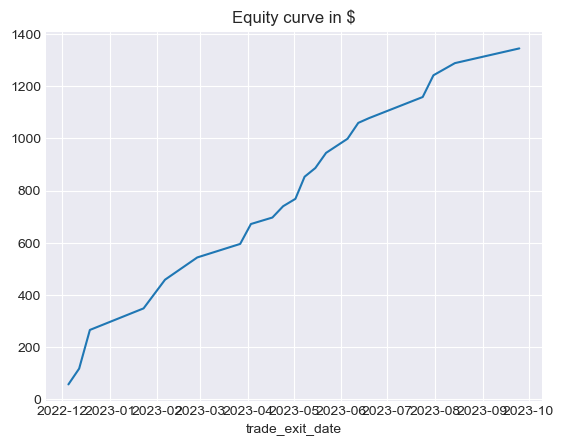

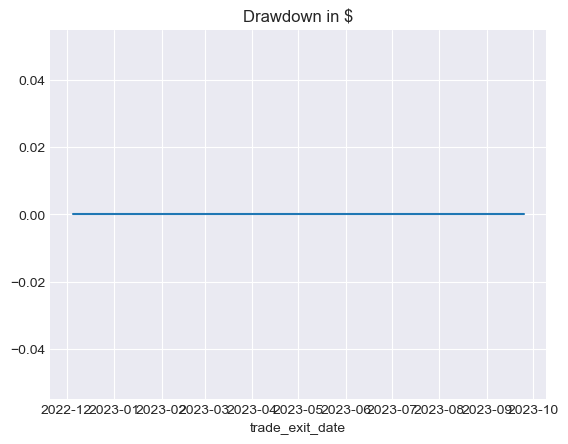

,Strategy
Total PnL,6726.50
Total Trades,30.00
Number of Winners,21.00
Number of Losers,9.00
Win (%),70.00
Loss (%),30.00
Per Trade PnL of Winners,320.31
Per Trade PnL of Losers,0.00
Profit Factor,inf


In [31]:
# Trade Level Analytics
# Assume lot size as 5
analytics = taf.trade_level_analytics(trade_details, lot_size)
analytics

## Notes

- The prior analysis did not consider transaction costs. To determine the true impact of delta hedging, we must examine the final PnL after accounting for the strategy's transaction costs.
- We have set a short-only straddle strategy, try tweaking the code by creating a long-short strategy.

## Conclusion

In this notebook, we create a backtesting script of a volatility-trading strategy and delta hedging. We encourage you to tweak the code to make a sensitivity analysis to find an optimized delta threshold, IV rank and Skew rank.